# Исследование надежности заемщиков.

## Описание проекта

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

**Цель исследования** — проверьте ответить на следующие исследовательские вопросы:
* Есть ли зависимость между количеством детей и возвратом кредита в срок?
* Есть ли зависимость между семейным положением и возвратом кредита в срок?
* Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
* Как разные цели кредита влияют на его возврат в срок?

### Шаг 1. Обзор данных

In [1]:
# импортируем библиотеку pandas
import pandas as pd 

# импортируем библиотеку seaborn для визуализации
import seaborn as sns

In [2]:
# загрузим данные и сохраним в переменную data
#data = pd.read_csv('data.csv')
data = pd.read_csv('/datasets/data.csv')

In [3]:
# посмотрим на первые 5 строк датасета и проверим как загрузились данные
data.head(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


На первый взгляд, данные загрузились корректно. 

Посмотрим на общую информацию о данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


В датасете 12 столбцов (переменных) и 21525 строк (данные по клиентам). Есть три типа данных float64, int64 и object. 

Согласно документации к данным: 
* `children` — количество детей в семье
* `days_employed` — общий трудовой стаж в днях
* `dob_years` — возраст клиента в годах
* `education` — уровень образования клиента
* `education_id` — идентификатор уровня образования
* `family_status` — семейное положение
* `family_status_id` — идентификатор семейного положения
* `gender` — пол клиента
* `income_type` — тип занятости
* `debt` — имел ли задолженность по возврату кредитов
* `total_income` — ежемесячный доход
* `purpose` — цель получения кредита

В двух столбцах `days_employed` (стаж работы в днях) и `total_income` (ежемесячный доход) есть пропуски (миссинги). 

#### Выводы 
В каждой строке таблицы представлены данные о каждом клиенте банка. Часть данных описывает семейные характеристики (семейное положение, число детей), другая часть описывает трудовые характеристики (стаж, доход), третья - личные характеристики такие, как пол, возраст. Оставшаяся часть раскрывает кредитную историю клиента и цель для получения кредита. 
Уровень образования и семейное положение представлено в двух форматах: числовом и строковом. Каждые уровень в соседней колонке закодирован числом. Далее мы этим воспользуемся. 

Предварительно можно утверждать, что, данных достаточно для проверки гипотез. Но встречаются пропуски в данных. Следует отметить, что названия колонок соответствуют хорошему стилю. 

Чтобы двигаться дальше, нужно устранить проблемы в данных.


## Предобработка данных

### Шаг 2.1 Заполнение пропусков

Сначала посчитаем количество пропусков

In [5]:
# подсчёт пропусков
data.isna().sum() 

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

In [6]:
data.isna().sum() / len(data) * 100

children             0.000000
days_employed       10.099884
dob_years            0.000000
education            0.000000
education_id         0.000000
family_status        0.000000
family_status_id     0.000000
gender               0.000000
income_type          0.000000
debt                 0.000000
total_income        10.099884
purpose              0.000000
dtype: float64

   Доля пропусков составляет примерно 10%. Отсутствие данных о стаже и ежемесячный доход можно объяснить тем, что клиент еще нигде не работал и не работает в настоящее время. Представляется, что пропуски неслучайные
Посмотрим на данные, где пропуски

In [7]:
data[data['days_employed'].isna() & data['total_income'].isna()].shape[0]

2174

Видим, что пропуски по этим данным у одних и тех же клиентов. Взглянем на первые 10 строк данных с пропусками.

In [8]:
data[data['days_employed'].isna() & data['total_income'].isna()].head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу
65,0,NaN,21,среднее,1,Не женат / не замужем,4,M,компаньон,0,NaN,операции с коммерческой недвижимостью
67,0,NaN,52,высшее,0,женат / замужем,0,F,пенсионер,0,NaN,покупка жилья для семьи
72,1,NaN,32,высшее,0,женат / замужем,0,M,госслужащий,0,NaN,операции с коммерческой недвижимостью
82,2,NaN,50,высшее,0,женат / замужем,0,F,сотрудник,0,NaN,жилье
83,0,NaN,52,среднее,1,женат / замужем,0,M,сотрудник,0,NaN,жилье


Сложно найти объяснение тому, почему нет данных о стаже и ежемесячном доходе. Возможно, что клиенты не указали эти данные. 

Не все пропущенные значения влияют на исследование. Так, в нашем случае, в стаж (`days_employed`) пропуски не важны для вашей работы. 
Но важны пропуски в переменной "ежемесячный доход" (`total_income`).
Заполним пропуски явными значениями. В данном случае переменные количественные и их лучше заменить медианным значением, поскольку медианное значение устойчиво к аномальным значениям (выбросам в данных / экстремально высоких или экстремальных низких значениях).
Но перед этим, сначала проверим данные на наличие аномалий и исправим их. И затем заполним пропуски медианным значением.

### Шаг 2.2 Проверка данных на аномалии и исправления.

Посмотрим на описательную статистику по всем количественным данным.

In [9]:
data.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


In [10]:
data.median()

children                 0.000000
days_employed        -1203.369529
dob_years               42.000000
education_id             1.000000
family_status_id         0.000000
debt                     0.000000
total_income        145017.937533
dtype: float64

В колонке `chidren` минимальное значение равно -1, вероятнее всего это произошла ошибка при вводе данных. 
Довольно странные значения наблюдаются в колонке `days_employed` - переменная "стаж". По идее, стаж не может быть отрицательным. Также странным кажется максимальное значение в этой переменной, поскольку 401755.400475 дней это более 1100 лет. Нужно будет внимательнее изучить данные в этой колонке.
Переменная "возраст клиента" (`dob_years`) не вызывает каких-либо подозрений. Так же, как и колонки `education_id`,  `family_status_id` и `debt` - это по сути категориальные данные, хотя и представлены в числовом виде. 

Посмотрим на данные в колонке - число детей. 

In [11]:
# посмотрим на уникальные значения в коллонке
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5])

In [12]:
# посмотрим на число уникальных значений
data['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Видим, что в данных -1 встречается 47 раз. Посмотрим на данные в таблице.

In [13]:
data[data['children'] == -1]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
291,-1,-4417.703588,46,среднее,1,гражданский брак,1,F,сотрудник,0,102816.346412,профильное образование
705,-1,-902.084528,50,среднее,1,женат / замужем,0,F,госслужащий,0,137882.899271,приобретение автомобиля
742,-1,-3174.456205,57,среднее,1,женат / замужем,0,F,сотрудник,0,64268.044444,дополнительное образование
800,-1,349987.852217,54,среднее,1,Не женат / не замужем,4,F,пенсионер,0,86293.724153,дополнительное образование
941,-1,NaN,57,Среднее,1,женат / замужем,0,F,пенсионер,0,NaN,на покупку своего автомобиля
1363,-1,-1195.264956,55,СРЕДНЕЕ,1,женат / замужем,0,F,компаньон,0,69550.699692,профильное образование
1929,-1,-1461.303336,38,среднее,1,Не женат / не замужем,4,M,сотрудник,0,109121.569013,покупка жилья
2073,-1,-2539.761232,42,среднее,1,в разводе,3,F,компаньон,0,162638.609373,покупка жилья
3814,-1,-3045.290443,26,Среднее,1,гражданский брак,1,F,госслужащий,0,131892.785435,на проведение свадьбы
4201,-1,-901.101738,41,среднее,1,женат / замужем,0,F,госслужащий,0,226375.766751,операции со своей недвижимостью


Поскольку отрицательное число детей быть не может. Заменим -1 на значение по модулю. Для этого воспользуемся функцией abs().

In [14]:
data['children'] = data['children'].replace(-1, 1)

In [15]:
# проверяем
data['children'].value_counts(sort=False)

0     14149
1      4865
2      2055
3       330
4        41
20       76
5         9
Name: children, dtype: int64

У 76 клиентов есть 20 детей (!)

Изучим данные клинетов, у которых 20 детей.

In [16]:
data[data['children'] == 20]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
606,20,-880.221113,21,среднее,1,женат / замужем,0,M,компаньон,0,145334.865002,покупка жилья
720,20,-855.595512,44,среднее,1,женат / замужем,0,F,компаньон,0,112998.738649,покупка недвижимости
1074,20,-3310.411598,56,среднее,1,женат / замужем,0,F,сотрудник,1,229518.537004,получение образования
2510,20,-2714.161249,59,высшее,0,вдовец / вдова,2,F,сотрудник,0,264474.835577,операции с коммерческой недвижимостью
2941,20,-2161.591519,0,среднее,1,женат / замужем,0,F,сотрудник,0,199739.941398,на покупку автомобиля
...,...,...,...,...,...,...,...,...,...,...,...,...
21008,20,-1240.257910,40,среднее,1,женат / замужем,0,F,сотрудник,1,133524.010303,свой автомобиль
21325,20,-601.174883,37,среднее,1,женат / замужем,0,F,компаньон,0,102986.065978,профильное образование
21390,20,NaN,53,среднее,1,женат / замужем,0,M,компаньон,0,NaN,покупка жилой недвижимости
21404,20,-494.788448,52,среднее,1,женат / замужем,0,M,компаньон,0,156629.683642,операции со своей недвижимостью


In [17]:
data[data['children'] == 20].describe() # рассмотрим описательную статистику

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,76.0,67.000000,76.000000,76.000000,76.000000,76.000000,67.000000
mean,20.0,35779.535997,41.815789,0.842105,0.815789,0.105263,168720.526180
std,0.0,112008.279425,12.065058,0.433671,1.363432,0.308931,80851.738318
min,20.0,-11937.171389,0.000000,0.000000,0.000000,0.000000,53971.576721
25%,20.0,-2629.663890,33.750000,1.000000,0.000000,0.000000,114668.631192
50%,20.0,-957.251278,41.500000,1.000000,0.000000,0.000000,144544.530170
75%,20.0,-478.364082,50.000000,1.000000,1.000000,0.000000,218033.697152
max,20.0,385267.263676,69.000000,2.000000,4.000000,1.000000,441721.334145


In [18]:
data[data['children'] == 20]['education_id'].value_counts()

1    60
0    14
2     2
Name: education_id, dtype: int64

In [19]:
data[data['children'] == 20]['family_status'].value_counts()

женат / замужем          49
гражданский брак         12
Не женат / не замужем     9
вдовец / вдова            4
в разводе                 2
Name: family_status, dtype: int64

In [20]:
data[data['children'] == 20]['gender'].value_counts()

F    47
M    29
Name: gender, dtype: int64

In [21]:
data.drop(data[data['children'] == 20].index, inplace=True) # удаляем клиентов с 20 детьми

Удалили строки с аномальными значениями в колонке `"children"`, и заменили отрицательные значения на положительные.

Рассмотрим внимательнее данные в колонке стаж. Посмотрим данные, где `days_employed` принимает положительные значения.

In [22]:
data[data['days_employed'] > 0].sort_values(by = 'days_employed').head(6)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
20444,0,328728.720605,72,среднее,1,вдовец / вдова,2,F,пенсионер,0,96519.339647,покупка жилья для семьи
9328,2,328734.923996,41,высшее,0,женат / замужем,0,M,пенсионер,0,126997.497760,операции со своей недвижимостью
17782,0,328771.341387,56,среднее,1,женат / замужем,0,F,пенсионер,0,68648.047062,операции с коммерческой недвижимостью
14783,0,328795.726728,62,высшее,0,женат / замужем,0,F,пенсионер,0,79940.196752,на покупку своего автомобиля
7229,1,328827.345667,32,среднее,1,гражданский брак,1,F,пенсионер,0,122162.965695,сыграть свадьбу
5332,0,328834.274455,55,среднее,1,женат / замужем,0,F,пенсионер,0,49802.142892,профильное образование


In [23]:
data[data['days_employed'] > 0].sort_values(by = 'days_employed').tail(6)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
4697,0,401635.032697,56,среднее,1,женат / замужем,0,F,пенсионер,0,48242.322502,покупка недвижимости
7794,0,401663.850046,61,среднее,1,гражданский брак,1,F,пенсионер,0,48286.441362,свадьба
2156,0,401674.466633,60,среднее,1,женат / замужем,0,M,пенсионер,0,325395.724541,автомобили
7664,1,401675.093434,61,среднее,1,женат / замужем,0,F,пенсионер,0,126214.519212,операции с жильем
10006,0,401715.811749,69,высшее,0,Не женат / не замужем,4,F,пенсионер,0,57390.256908,получение образования
6954,0,401755.400475,56,среднее,1,вдовец / вдова,2,F,пенсионер,0,176278.441171,ремонт жилью


Возможно, что положительные значения в `days_employed` у пенсионеров? Проверим

In [24]:
data[data['days_employed'] > 0].shape[0]

3438

In [25]:
data[(data['days_employed'] > 0) & (data['income_type'] == 'пенсионер')].shape[0]

3436

In [26]:
data[(data['days_employed'] > 0) & (data['income_type'] != 'пенсионер')]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
3133,1,337524.466835,31,среднее,1,женат / замужем,0,M,безработный,1,59956.991984,покупка жилья для сдачи
14798,0,395302.838654,45,Высшее,0,гражданский брак,1,F,безработный,0,202722.511368,ремонт жилью


В основном получается, что положительный стаж у категории "пенсионер". Но все равно странно. 

In [27]:
data[data['days_employed'] > 0]['days_employed'].min()

328728.72060451825

In [28]:
# найдем долю аномальных значений
3436/len(data) * 100

16.01939484358245

Но все равно странно. Минимальное положительное значение равно 328728.72060451825, а это примерно 900 лет. Такого быть не может. 
Доля аномальных значений около 16%, это много. Удалять из дасета не будем. Поэтому заменим такие аномальные значения медианным значением.Точно также заменим пропуски медианным значением.
Трудно объяснить причину почему в данных `days_employed` значения представлены таким образом. Я бы обратилась к тем, кто выгружал данные, но сделать это в рамках проекта невозможно.

В `total_income` видим, что размах в данных довольно большой. В тому же медиана и среднее сильно отличаются друг от друга.

Посмотрим на данные более подробно. Разделим данные на 3 категории данные из колонки `total_income`.

In [29]:
pd.cut(data['total_income'], 3, labels=["low", "medium", "high"]).value_counts()

low       19239
medium       38
high          7
Name: total_income, dtype: int64

Итак, замечаем, что очень много низких значений. Поэтому лучше заменить пропуски в `total_income` на медианное значение.

Проверим есть ли аномалии в столблцах возраста и пола.

In [30]:
# рассмотрим данные, гдe очень высокий ежемесячный доход
data[pd.cut(data['total_income'], 3, labels=["low", "medium", "high"]) == 'high']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
9169,1,-5248.554336,35,среднее,1,гражданский брак,1,M,сотрудник,0,1.726276e+06,дополнительное образование
12412,0,-1477.438114,44,высшее,0,женат / замужем,0,M,компаньон,0,2.265604e+06,ремонт жилью
17178,0,-5734.127087,42,высшее,0,гражданский брак,1,M,компаньон,0,1.711309e+06,сыграть свадьбу
17503,0,-2285.476482,43,среднее,1,женат / замужем,0,M,компаньон,0,1.597613e+06,операции с недвижимостью
18368,1,-333.935516,41,ВЫСШЕЕ,0,гражданский брак,1,M,компаньон,0,1.551153e+06,свадьба
19606,1,-2577.664662,39,высшее,0,женат / замужем,0,M,компаньон,1,2.200852e+06,строительство недвижимости
20809,0,-4719.273476,61,среднее,1,Не женат / не замужем,4,F,сотрудник,0,1.715018e+06,покупка жилья для семьи


Итак, у таких клиентов уровень образования высшее или среднее, в основном они женаты или замужем. 6 из 7 являются мужчинами. Если обратить внимание на род занятости, то это в основном компаньоны. Вполне можно предположить, что эти люди являются успешными предпринимателями, за исключением двух сотрудников. 

Посмотрим, общую долю компаньонов во всем датасете.

In [31]:
data['income_type'].value_counts() / len(data) * 100

сотрудник          51.638771
компаньон          23.604830
пенсионер          17.935568
госслужащий         6.792857
предприниматель     0.009324
безработный         0.009324
студент             0.004662
в декрете           0.004662
Name: income_type, dtype: float64

Рассмотрим ежемесячный доход для каждой категории занятости

In [32]:
data.groupby('income_type')['total_income'].median().sort_values(ascending=False)

income_type
предприниматель    499163.144947
компаньон          172450.279990
госслужащий        150420.150276
сотрудник          142594.396847
безработный        131339.751676
пенсионер          118406.283533
студент             98201.625314
в декрете           53829.130729
Name: total_income, dtype: float64

In [33]:
data.groupby('income_type')['total_income'].mean().sort_values(ascending=False)

income_type
предприниматель    499163.144947
компаньон          202522.888321
госслужащий        170831.866373
сотрудник          161345.582776
пенсионер          137150.779099
безработный        131339.751676
студент             98201.625314
в декрете           53829.130729
Name: total_income, dtype: float64

In [34]:
data[data['income_type'] == 'предприниматель']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
5936,0,NaN,58,высшее,0,женат / замужем,0,M,предприниматель,0,NaN,покупка жилой недвижимости
18697,0,-520.848083,27,высшее,0,гражданский брак,1,F,предприниматель,0,499163.144947,на проведение свадьбы


Итак, если исключить предпринимателей (их всего 2 в датасете, и только у одного указан дохож), то средний и медианный ежемесячный доход у компаньонов выше, чем у остальных категорий работников. Вполне возможно, что у некоторых компаньонов довольно успешный бизнес.
Медианное значение `'total_income'` равно `145020.80`, что в целом похоже на правду, если смотреть на медианные и средние доходы в разрезе категорий работников.  
Предлагаю удалить из датасета клиента-"предпринимателя", у которого не указан ежемесячный доход. 

In [35]:
data.drop(data[data['income_type'] == 'предприниматель'].index, inplace=True) # удаляем клиентов с 20 детьми

Рассмотрим также различия в доходах в зависимости от пола.

In [36]:
data['gender'].value_counts() 

F      14188
M       7258
XNA        1
Name: gender, dtype: int64

Женщин клиентов практически в два раза больше, чем мужчин. 

И у нас есть строка, где неверно указан пол клиента.

In [37]:
data[data['gender'] == 'XNA']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10701,0,-2358.600502,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905.157261,покупка недвижимости


В общем, выглядит странно, конечно. Этот клиент является компаньоном, и него довольно высокий ежемесячный доход. Посмотрим, какова доля компаньонов среди клиентов, у которых доход больше 200000 ед.

In [38]:
(data[data['total_income'] > 200000]['income_type']
 .value_counts() / len(data[data['total_income'] > 200000]) * 100)

сотрудник      47.056492
компаньон      34.687810
пенсионер      10.941526
госслужащий     7.294351
безработный     0.019822
Name: income_type, dtype: float64

In [39]:
(data[data['total_income'] <= 200000]['income_type']
 .value_counts() / len(data[data['total_income'] <= 200000]) * 100)

сотрудник      53.378283
пенсионер      20.255654
компаньон      19.721871
госслужащий     6.623121
студент         0.007023
в декрете       0.007023
безработный     0.007023
Name: income_type, dtype: float64

Доля компаньонов, у которых доход больше 200000 ед., довольно большая, можно удалить одного клиента из анализа.

In [40]:
data.drop(data[data['gender'] == 'XNA'].index, inplace=True) # удаляем клиентов с 20 детьми

In [41]:
data.groupby('gender')['total_income'].median()

gender
F    134148.57593
M    167756.23024
Name: total_income, dtype: float64

In [42]:
data.groupby('gender')['total_income'].mean()

gender
F    154048.885895
M    193216.720443
Name: total_income, dtype: float64

И среднее, и медианное значение дохода у мужчин больше. 

Рассмотрим различия в доходах в зависимости от пола и типа занятости.

In [43]:
data.groupby('gender')['income_type'].value_counts()

gender  income_type
F       сотрудник      6776
        компаньон      3187
        пенсионер      3150
        госслужащий    1073
        безработный       1
        в декрете         1
M       сотрудник      4300
        компаньон      1875
        пенсионер       697
        госслужащий     384
        безработный       1
        студент           1
Name: income_type, dtype: int64


Видим, что распределение по типу занятости у мужчин и женщин одинаковая. Но поскольку женщин практически в два раза больше, чем мужчин, и медианные значения ежемесячного дохода различаются, то лучше заменить пропуски в `'total_income'` для мужчин и женщин отдельно. У каждой категории по полу свое медианное значение.


### Замена пропусков и аномальных значений

In [44]:
# заменяем пропуски медианным значением 
data.loc[data['gender'] == 'F', 'total_income'] = data.loc[data['gender'] == 'F', 'total_income'].fillna(data['total_income'].median())

In [45]:
# проверим что миссингов не осталось
data.loc[data['gender'] == 'F', 'total_income'].isnull().sum() 

0

In [46]:
# проверим что остались миссинги у мужчин
data.loc[data['gender'] == 'M', 'total_income'].isnull().sum() # проверяем, что пропусков не осталось

686

In [47]:
# заменяем пропуски медианным значением 
data.loc[data['gender'] == 'M', 'total_income'] = data.loc[data['gender'] == 'M', 'total_income'].fillna(data['total_income'].median())

In [48]:
data['total_income'].isnull().sum() # проверяем, что пропусков не осталось

0

In [49]:
# заменияем аномалии
# сначала найдем медианное значение по отрицательным значениям
days_employed_median = abs(data[data['days_employed'] <= 0]['days_employed'].median())

In [50]:
# напишем функцию, которая будет заменять старое значение в строке на новое
def replace_data(days):
    if days > 0:
        return days_employed_median
    else:
        return days

In [51]:
data['days_employed'] = data['days_employed'].apply(replace_data)

In [52]:
# заменияем аномалии в days_employed
# сначала избавимся от отрицательных чисел
data['days_employed'] = data['days_employed'].abs()

In [53]:
data['days_employed'].describe()

count    19282.000000
mean      2225.035854
std       2106.993077
min         24.141633
25%        928.043735
50%       1631.100855
75%       2747.944869
max      18388.949901
Name: days_employed, dtype: float64

Заменили аномалии на медианное значение. Теперь заменим пропуски.

In [54]:
# заменяем пропуски в переменной стаж
data['days_employed'] = data['days_employed'].fillna(data['days_employed'].median())

In [55]:
# проверяем, что пропусков не осталось
data['days_employed'].isnull().sum() # проверяем, что пропусков не осталось

0

Пропуски заменили медианным значением в `'days_employed'`, но числа в этом столбце отрицательные. Хорошо бы заменить на положительные. Но поскольку в дальнейшем анализе эти данные нам не понадобятся, то проще игнорировать этот столбец, а лучше обратиться к работникам, которые выгружают данные и выяснить причину такого формата данных.

Итак, заменили все пропуски в данных.

In [107]:
# КОД РЕВЬЮЕРА

data.dob_years.sort_values().unique()

array([ 0, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75])

### Шаг 2.3. Изменение типов данных.

Заменим вещественный тип данных в столбце `total_income` на целочисленный, например, с помощью метода `astype()`.

In [56]:
data['total_income'] = data['total_income'].astype('int')

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21446 entries, 0 to 21524
Data columns (total 12 columns):
children            21446 non-null int64
days_employed       21446 non-null float64
dob_years           21446 non-null int64
education           21446 non-null object
education_id        21446 non-null int64
family_status       21446 non-null object
family_status_id    21446 non-null int64
gender              21446 non-null object
income_type         21446 non-null object
debt                21446 non-null int64
total_income        21446 non-null int64
purpose             21446 non-null object
dtypes: float64(1), int64(6), object(5)
memory usage: 2.1+ MB


Изменение прошло успешно.

### Шаг 2.4. Удаление дубликатов.

Проверим данные на наличие дубликатов. Как явных, так и неявных.
Сначала попробуем выявить неявные дубли в категориальных переменных, появившихся из-за разного регистра, опечаток, транслитерацией и прочее в колонках семейное положение, тип занятости и цель кредитования нет.

Потом выясним есть ли явные дубликаты с помощью методов `duplicated()` и `sum()`. Метод `duplicated()` находит явные дубли в таблице и возрващает булево значение (True/False), их можно просуммировать и найти общее число дублей.

In [58]:
# рассмотрим переменную education
data['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

In [59]:
data['education'].value_counts()

среднее                13698
высшее                  4704
СРЕДНЕЕ                  770
Среднее                  705
неоконченное высшее      665
ВЫСШЕЕ                   272
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ             1
Ученая степень             1
Name: education, dtype: int64

Есть неявные дубли. Приведем все к единому нижнему регистру. 

In [60]:
data['education'] = data['education'].str.lower()

In [61]:
data['education'].value_counts()

среднее                15173
высшее                  5244
неоконченное высшее      741
начальное                282
ученая степень             6
Name: education, dtype: int64

In [62]:
# проверим есть ли неявные дубли в колонке семейное положение
data['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

In [63]:
# проверим есть ли неявные дубли в колонке тип занятости
data['income_type'].unique()

array(['сотрудник', 'пенсионер', 'компаньон', 'госслужащий',
       'безработный', 'студент', 'в декрете'], dtype=object)

In [64]:
# проверим есть ли неявные дубли в колонке цель кредитования
data['purpose'].sort_values().unique()

array(['автомобили', 'автомобиль', 'высшее образование',
       'дополнительное образование', 'жилье',
       'заняться высшим образованием', 'заняться образованием',
       'на покупку автомобиля', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля', 'на проведение свадьбы',
       'недвижимость', 'образование', 'операции с жильем',
       'операции с коммерческой недвижимостью',
       'операции с недвижимостью', 'операции со своей недвижимостью',
       'покупка жилой недвижимости', 'покупка жилья',
       'покупка жилья для сдачи', 'покупка жилья для семьи',
       'покупка коммерческой недвижимости', 'покупка недвижимости',
       'покупка своего жилья', 'получение высшего образования',
       'получение дополнительного образования', 'получение образования',
       'приобретение автомобиля', 'профильное образование',
       'ремонт жилью', 'свадьба', 'свой автомобиль',
       'сделка с автомобилем', 'сделка с подержанным автомобилем',
       'строительство 

Неявных дублей, вызванных из-за разного регистра, опечаток, транслитерацией и прочее в колонках семейное положение, тип занятости и цель кредитования нет.

In [65]:
data.duplicated().sum()

71

В данных 71 явный дубликат. Дубли могли возникнуть из-за того, что данные о клиенте могли быть внесены несколько раз. Удалим их при помощи метода `drop_duplicates()` и обновим индексацию.

In [66]:
data = data.drop_duplicates().reset_index(drop=True)

In [67]:
data.duplicated().sum() # проверяем

0

Дублей не осталось.

### Шаг 2.5. Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.

Сейчас в данных в четырех колонках представлены по сути две информации. В колонке `education` и `family_status` уровень образования и семейное положение соответственно в виде строки, а в колонках `education_id` и `family_status_id` их числовая кодировка. 
Для того, чтобы упростить работу с таблицей создадим два новых датафрейма со столбцами `education` и `education_id`, `family_status` и `family_status_id`. Новые датафреймы будут выступать в качестве «словарей», к которым мы сможем затем обращаться по идентификатору.

In [68]:
# создадим датафрейм education_level
education_level = data[['education_id', 'education']]
display(education_level.head(5))

,education_id,education
0,0,высшее
1,1,среднее
2,1,среднее
3,1,среднее
4,1,среднее


In [69]:
# удалим дубли в education_level
education_level = education_level.drop_duplicates().reset_index(drop=True)

In [70]:
display(education_level)

,education_id,education
0,0,высшее
1,1,среднее
2,2,неоконченное высшее
3,3,начальное
4,4,ученая степень


In [71]:
# создадим датафрейм family_status
family_status = data[['family_status_id', 'family_status']]
display(family_status.head(5))

,family_status_id,family_status
0,0,женат / замужем
1,0,женат / замужем
2,0,женат / замужем
3,0,женат / замужем
4,1,гражданский брак


In [72]:
# удалим дубли 
family_status = family_status.drop_duplicates().reset_index(drop=True)

In [73]:
display(family_status)

,family_status_id,family_status
0,0,женат / замужем
1,1,гражданский брак
2,2,вдовец / вдова
3,3,в разводе
4,4,Не женат / не замужем


Удалим колонки `education` и `family_status` из основного датафрейма.

In [74]:
# воспользуемся методом drop
data.drop(columns = ['education', 'family_status'],axis = 1, inplace=True)

In [75]:
# проверим
data.columns

Index(['children', 'days_employed', 'dob_years', 'education_id',
       'family_status_id', 'gender', 'income_type', 'debt', 'total_income',
       'purpose'],
      dtype='object')

Столбцы удалены.

### Шаг 2.6. Категоризация дохода.

На основании диапазонов, указанных ниже, создадим столбец `total_income_category` с категориями:
* `0–30000` — `'E'`;
* `30001–50000` — `'D'`;
* `50001–200000` — `'C'`;
* `200001–1000000` — `'B'`;
* `1000001 и выше` — `'A'`.

Например, кредитополучателю с доходом `25000` нужно назначить категорию `'E'`, а клиенту, получающему `235000`, — `'B'`.

In [76]:
# пропишем функцию, которая поможет выполнить эту задачу

def income_group(income):
    if income <= 30000:
        return 'E'
    elif income <= 50000:
        return 'D'
    elif income <= 200000:
        return 'C'
    elif income <= 1000000:
        return 'B'
    else:
        return 'A'

In [77]:
# проверим, что функция работает
array = [0, 25000, 45000, 65000, 235000, 1000010]
for item in array:
    print(income_group(item))

E
E
D
C
B
A


Функция работает.  
Применим её к колонке `total_income`.

In [78]:
# использоуем собственную функцию и метод apply()
data['total_income_category'] = data['total_income'].apply(income_group)
display(data.head(10))

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category
0,1,8437.673028,42,0,0,F,сотрудник,0,253875,покупка жилья,B
1,1,4024.803754,36,1,0,F,сотрудник,0,112080,приобретение автомобиля,C
2,0,5623.422610,33,1,0,M,сотрудник,0,145885,покупка жилья,C
3,3,4124.747207,32,1,0,M,сотрудник,0,267628,дополнительное образование,B
4,0,1631.100855,53,1,1,F,пенсионер,0,158616,сыграть свадьбу,C
5,0,926.185831,27,0,1,M,компаньон,0,255763,покупка жилья,B
6,0,2879.202052,43,0,0,F,компаньон,0,240525,операции с жильем,B
7,0,152.779569,50,1,0,M,сотрудник,0,135823,образование,C
8,2,6929.865299,35,0,1,F,сотрудник,0,95856,на проведение свадьбы,C
9,0,2188.756445,41,1,0,M,сотрудник,0,144425,покупка жилья для семьи,C


In [79]:
data['total_income_category'].value_counts() # посмотрим как распределились наши данные

C    15959
B     5019
D      350
A       25
E       22
Name: total_income_category, dtype: int64

Большая часть клиентов попадают в категорию `'C'`, реже встречаются клинеты с доходом выше 200000 ден.ед.

### Шаг 2.7. Категоризация целей кредита.

Создайдим функцию, которая на основании данных из столбца `purpose` сформирует новый столбец `purpose_category`, в который войдут следующие категории:
* `'операции с автомобилем'`,
* `'операции с недвижимостью'`,
* `'проведение свадьбы'`,
* `'получение образования'`.  

Например, если в столбце purpose находится подстрока `'на покупку автомобиля'`, то в столбце `purpose_category` должна появиться строка `'операции с автомобилем'`.

Для этого изучим данные в столбце `purpose` и определим, какие подстроки помогут нам правильно определить категорию.

In [80]:
data['purpose'].sort_values().unique()

array(['автомобили', 'автомобиль', 'высшее образование',
       'дополнительное образование', 'жилье',
       'заняться высшим образованием', 'заняться образованием',
       'на покупку автомобиля', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля', 'на проведение свадьбы',
       'недвижимость', 'образование', 'операции с жильем',
       'операции с коммерческой недвижимостью',
       'операции с недвижимостью', 'операции со своей недвижимостью',
       'покупка жилой недвижимости', 'покупка жилья',
       'покупка жилья для сдачи', 'покупка жилья для семьи',
       'покупка коммерческой недвижимости', 'покупка недвижимости',
       'покупка своего жилья', 'получение высшего образования',
       'получение дополнительного образования', 'получение образования',
       'приобретение автомобиля', 'профильное образование',
       'ремонт жилью', 'свадьба', 'свой автомобиль',
       'сделка с автомобилем', 'сделка с подержанным автомобилем',
       'строительство 

In [81]:
# напишем функцию 
def purpose_group(row):
    if 'автомобил' in row: # если слово 'автомобил' содержатся в row
        return 'операции с автомобилем' # то возвращаем такое значение и т.д.
    elif 'образовани' in row:
        return 'получение образования'
    elif 'свадьб' in row:
        return 'проведение свадьбы'
    else:
        return 'операции с недвижимостью'

In [82]:
data['purpose_category'] = data['purpose'].apply(purpose_group)

In [83]:
data['purpose_category'].value_counts()

операции с недвижимостью    10773
операции с автомобилем       4290
получение образования        3998
проведение свадьбы           2314
Name: purpose_category, dtype: int64

Итак, мы категоризировали цели кредита. Видим, что большинство клинетов берут кредит для совершения операций с недвижимостью. Реже берут кредит (или реже указывают, что цель кредита) на проведение свадьбы.

Данные подготовлены. Приступим к анализу данных и ответим на поставленные вопросы.

### Ответы на вопросы.

##### Вопрос 1: Есть ли зависимость между количеством детей и возвратом кредита в срок?

Для ответа на этот вопрос построим график `bar-plot` и найдем  долю тех, у кого была задолжность по кредиту в зависимости от числа детей.

In [84]:
data.groupby('children')['debt'].mean() * 100 # найдем долю

children
0    7.545429
1    9.165808
2    9.454191
3    8.181818
4    9.756098
5    0.000000
Name: debt, dtype: float64

Итак, видим, что больших различий в задолжностей по кредиту в зависимости от числа детей не видим. Хотя доля должников меньше у группы клиентов без детей, а наибольшая доля задолжностей наблюдается у клиентов, у которых 20 детей. Абсолютно нет должников среди клиентов, у которых 5 детей. 

Но давайте посмотрим еще раз на распределение клиентов по числу детей. 

In [85]:
data.groupby('children')['children'].count()

children
0    14088
1     4855
2     2052
3      330
4       41
5        9
Name: children, dtype: int64

Как видно из аутпута выше, крайне мало людей, у которых более 3 детей. Число клиентов у которых 3 детей тоже на порядок меньше, чем клиентов у которых 1-2 ребенка. Давайте объединим категории клиентов у которых 3 и более детей в группу "более 2-х детей"

In [86]:
# напишем функцию 
def children_group(num):
    if num > 2:
        return 'более 2-х детей'
    elif num == 2:
        return '2 детей'
    elif num == 1:
        return '1 ребенок'
    else:
        return 'нет детей'

In [87]:
data['children_category'] = data['children'].apply(children_group)

In [88]:
data.groupby('children_category')['children_category'].count()

children_category
1 ребенок           4855
2 детей             2052
более 2-х детей      380
нет детей          14088
Name: children_category, dtype: int64

In [89]:
data.groupby('children_category')['debt'].mean() * 100 # найдем долю

children_category
1 ребенок          9.165808
2 детей            9.454191
более 2-х детей    8.157895
нет детей          7.545429
Name: debt, dtype: float64

Результаты немного изменились для категории клиентов "более 2-х детей", но представленность этой категории в общей выборке достаточно мала.

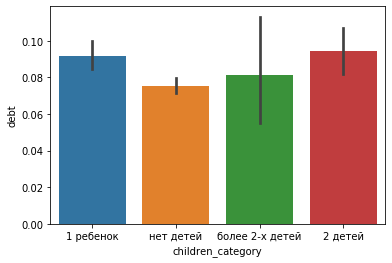

In [90]:
# построим график 
sns.barplot(x='children_category', y='debt', data=data)

##### Вывод 1:

Полученные результаты показывают, что клиенты, у которых нет детей чаще возвращают кредит. Клиенты, у которых 1-2 ребенка имеют больше задолжностей по кредиту. Многодетные клиенты (более 2-х детей) в среднем возвращают кредит чаще, чем клиенты с 1-2 ребенком, но поскольку таких клиентов мало, то тут все-таки требуется более детальная проверка. 
Можно было бы также поделить выборку на две группы: есть дети и нет детей. И посмотреть среднюю задолжность. Но задача стояла в проверке поиска связи между числом детей и возвратом кредита в срок.

Проверим каковы различия в средней задолжности в зависимости от наличия детей. Добавим дихотомическую переменную есть 

In [91]:
# напишем функцию 
def has_children(num):
    if num == 0:
        return 'нет детей'
    else:
        return 'есть дети'

In [92]:
data['has_children'] = data['children'].apply(has_children)

In [93]:
data.groupby('has_children')['children_category'].count()

has_children
есть дети     7287
нет детей    14088
Name: children_category, dtype: int64

In [94]:
data.groupby('has_children')['debt'].mean() * 100 # найдем долю

has_children
есть дети    9.194456
нет детей    7.545429
Name: debt, dtype: float64


Как видно из результатов, средняя задолжность у клиентов без детей меньше, чем у клиентов с детьми.



##### Вопрос 2: Есть ли зависимость между семейным положением и возвратом кредита в срок?

Так же, как и в предыдущем вопросе построим график bar-plot и найдем долю тех, у кого была задолжность по кредиту в зависимости от семейного положения.

In [95]:
data_family_status = data.pivot_table(index=['family_status_id'], values='debt', aggfunc='mean') * 100
display(data_family_status)

,debt
family_status_id,
0,7.551469
1,9.306261
2,6.596859
3,7.041073
4,9.746519


In [96]:
data_family_status = data_family_status.merge(family_status, on='family_status_id', how='left')

In [97]:
data_family_status

,family_status_id,debt,family_status
0,0,7.551469,женат / замужем
1,1,9.306261,гражданский брак
2,2,6.596859,вдовец / вдова
3,3,7.041073,в разводе
4,4,9.746519,Не женат / не замужем


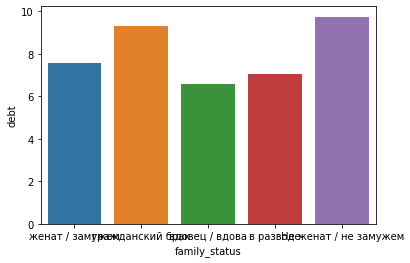

In [98]:
# построим график 
sns.barplot(x='family_status', y='debt', data=data_family_status)

In [99]:
# проверим распределение людей по семейному положению
data.groupby('family_status_id')['family_status_id'].count()

family_status_id
0    12289
1     4137
2      955
3     1193
4     2801
Name: family_status_id, dtype: int64

##### Вывод 2:

Результаты показывают, что не женатые и не замужные клиенты, а также клиенты, состоящие в гражданском браке чаще имеют задолжности по кредиту. Чаще всего возвращают в срок клиенты-вдовцы(вдовы). Промежуточное положение занимают клиенты в браке и разведенные.  

##### Вопрос 3: Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Проверим существует ли зависимость между уровнем дохода и возвратом кредита в срок. Для этого воспользуемся переменной, где клиенты распределены по категориям в зависимости от ежемесячного дохода.

In [100]:
data.groupby('total_income_category')['debt'].mean() * 100 # найдем долю

total_income_category
A    8.000000
B    7.053198
C    8.484241
D    6.000000
E    9.090909
Name: debt, dtype: float64

In [101]:
data.groupby('total_income_category')['total_income_category'].count() # напомним как были распределены клиенты по доходу

total_income_category
A       25
B     5019
C    15959
D      350
E       22
Name: total_income_category, dtype: int64

##### Вывод 3:

Клиенты с низким уровнем дохода (менее 30000) реже возвращают кредит в срок. Но таких клиентов так же, как и клиентов с ежемесячным доходом свыше 1000000 крайне мало в дататсете. Поэтому сложно судить насколько будут верны эти данные для большей выборки клиентов, представляющих эти категории.

Средний процент задолжности у наиболее распространенной категории клиентов (`'C'`) составляет 8,5%. Иными словами, каждый 9 не возвращает кредит в срок. 
Чаще всего кредит возвращают в срок клиенты с доходом от 30001–50000 и 200001–1000000. 

##### Вопрос 4: Как разные цели кредита связаны с его возвратом в срок?

И теперь проверим связаны задолжности по кредиту с его целями. 
Построим сводную таблицу со средними значениями.

In [102]:
data.groupby('purpose_category')['debt'].mean() * 100 # найдем долю

purpose_category
операции с автомобилем      9.347319
операции с недвижимостью    7.240323
получение образования       9.229615
проведение свадьбы          7.908384
Name: debt, dtype: float64

In [103]:
data.groupby('purpose_category')['purpose_category'].count() 

purpose_category
операции с автомобилем       4290
операции с недвижимостью    10773
получение образования        3998
проведение свадьбы           2314
Name: purpose_category, dtype: int64

##### Вывод 4:

Клиенты в среднем чаще возвращают кредит вовремя, если целью кредита были операции с недвижимостью. По кредитам полученным для проведения операций с автомобилями или для получения образования, в среднем имеется больше задолжностей.

## Общий вывод:

Мы ответили на четыре исследовательских вопроса и установили:

1) Исследование зависимости возрата кредита в срок и количеством детей у клиента показало, что клиенты без детей скорее закроют кредит в срок, чем клиенты у которых есть дети. Средний процент невозврата среди клиентов с детьми составляет 9% против 7,5% у клиентов без детей. 
Хотя здесь непременно требуется статистический анализ данных для проверки достоверности полученных результатов.

2) Возрат кредита в срок отличается также в зависимости от семейного положения клиента. Так не женатые / не замужные клиенты  и клиенты, состоящие в гражданском браке, реже возвращают по кредиту по сравнению с остальными клиентами (средний процент 9,7% и 9,3% соответственно). Клиенты-вдовцы(вдовы) в среднем чаще возвращают кредит в срок (6,6%). Промежуточное положение занимают клиенты в браке и разведенные (7-7,5%).

3) Задолжности по кредиту связаны и ежемесячным доходом. Клиенты с низким уровнем дохода (менее `30000`) в среднем имеют больше задолжностей по кредиту. Клиенты с ежемесячным доходом свыше `1000000` тоже в среднем имеют больше задолжностей по кредитам (9%), чем клиенты других категорий (`B`, `C`, `D`). Но отметим, что клиентов категорий `E` и `A` крайне мало в наших данных (в сумее менее 50 человек). Поэтому сложно судить насколько будут верны эти данные для большей выборки клиентов, представляющих эти категории. Средний процент задолжности у наиболее распространенной категории клиентов (`C`) составляет 8,5%. Чаще всего кредит возвращают в срок клиенты с доходом от `30001–50000` и `200001–1000000` (6% и 7% соответственно).

4) Возрат кредита в срок также различается в зависимости от цели кредита. Самые надежные клиенты - это те, кто берет кредит с целью проведения операций с недвижимостью. Средний процент задолжности у этих клинетов составляет 7,2%. Клиенты, которые берут кредиты на образование или автокредиты, в среднем показывают относительной высокий процент задолжности (примерно 9%). 